# Project: GDP Per Capita and Number of Infant Deaths

GDP per capita in current 'international dollarsGDP per capita (PPP based) is gross domestic product converted to international dollars using purchasing power parity rates and divided by total population. In this project, my aim is to discover if GDP per capita income is related to number of infant mortality or if there is no relation between them.  

## Getting the Data

My two datasets were gotten from World bank's databank using the code indicator. The data for GDP per capita is available at <a>"https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD"</a> and the data for number of infant death is available at  <a>"https://data.worldbank.org/indicator/SH.DTH.IMRT?view=chart"</a>

In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

import pandas as pd

In [2]:
GDP_IND = 'NY.GDP.PCAP.PP.CD'
MORT_IND = 'SH.DTH.IMRT'

In [3]:
if pd.__version__.startswith('0.23'):
    # this solves an incompatibility between pandas 0.23 and datareader 0.6
    # taken from https://stackoverflow.com/questions/50394873/
    core.common.is_list_like = api.types.is_list_like

from pandas_datareader.wb import download

YEAR = 2019
gdpWB = download(indicator=GDP_IND, country='all', start=YEAR, end=YEAR)
mortWB = download(indicator=MORT_IND, country='all', start=YEAR, end=YEAR)

In [4]:
gdpWB.head()

,,NY.GDP.PCAP.PP.CD
country,year,
Arab World,2019,15256.338996
Caribbean small states,2019,16550.859093
Central Europe and the Baltics,2019,34113.571814
Early-demographic dividend,2019,9693.772411
East Asia & Pacific,2019,18400.413124


In [5]:
mortWB.head()

,,SH.DTH.IMRT
country,year,
Arab World,2019,273955.0
Caribbean small states,2019,1703.0
Central Europe and the Baltics,2019,3982.0
Early-demographic dividend,2019,1800833.0
East Asia & Pacific,2019,360014.0


In [6]:
gdp_ppp = gdpWB.reset_index()

In [7]:
childmort = mortWB.reset_index()

### Cleaning and Transforming The Data

In [8]:
#removing unwanted and empty rows

gdp_ppp = gdp_ppp[47:].dropna()
childmort = childmort[47:].dropna()

In [9]:
childmort.head()

,country,year,SH.DTH.IMRT
47,Afghanistan,2019,55797.0
48,Albania,2019,290.0
49,Algeria,2019,20237.0
51,Andorra,2019,2.0
52,Angola,2019,63216.0


In [10]:
gdp_ppp.head()

,country,year,NY.GDP.PCAP.PP.CD
47,Afghanistan,2019,2156.419482
48,Albania,2019,14224.098074
49,Algeria,2019,12019.928356
52,Angola,2019,6965.511374
53,Antigua and Barbuda,2019,22879.766094


My data for GPD is already in international dollars which is a good thing but for easy readability, I will round up the data to the nearest whole numbers. Then format infant mortality number column to integers. 

In [13]:
def roundToMillions(value):
    return round(value)                 

GDP = 'GDP (Int $)'            #International dollars
gdp_ppp[GDP] = gdp_ppp[GDP_IND].apply(roundToMillions)
gdp_ppp.head()

,country,year,NY.GDP.PCAP.PP.CD,GDP (Int $)
47,Afghanistan,2019,2156.419482,2156
48,Albania,2019,14224.098074,14224
49,Algeria,2019,12019.928356,12020
52,Angola,2019,6965.511374,6966
53,Antigua and Barbuda,2019,22879.766094,22880


In [14]:
#To remove unwanted rows

COUNTRY = 'country'
headings = [COUNTRY, GDP]
gdp_ppp = gdp_ppp[headings]
gdp_ppp.head()

,country,GDP (Int $)
47,Afghanistan,2156
48,Albania,14224
49,Algeria,12020
52,Angola,6966
53,Antigua and Barbuda,22880


In [15]:
Death_NUM = 'Infant Mortality (Number)'
childmort[Death_NUM] = childmort[MORT_IND].apply(round)
headings = [COUNTRY, Death_NUM]
childmort = childmort[headings]
childmort.head()

,country,Infant Mortality (Number)
47,Afghanistan,55797
48,Albania,290
49,Algeria,20237
51,Andorra,2
52,Angola,63216


### Joining The Data

I will merge the tables through an inner join on the common 'country' column.

In [16]:
gdp_pppVschildmort = pd.merge(gdp_ppp, childmort, on=COUNTRY, how='inner')
gdp_pppVschildmort.head()

,country,GDP (Int $),Infant Mortality (Number)
0,Afghanistan,2156,55797
1,Albania,14224,290
2,Algeria,12020,20237
3,Angola,6966,63216
4,Antigua and Barbuda,22880,9


### Calculating The Correlation 

Using Spearman rank correlation, I will measure if the infant death number of a country correlate with the GDP per capita of that country. If there is a relationship btween these. Spearman rank correlation is a number from -1 (perfect inverse rank correlation: if one indicator increases, the other decreases) to 1 (perfect direct rank correlation: if one indicator increases, so does the other), with 0 meaning there is no rank correlation. A perfect correlation doesn't imply any cause-effect relation between the two indicators. A p-value below 0.05 means the correlation is statistically significant.

In [17]:
from scipy.stats import spearmanr

gdpColumn = gdp_pppVschildmort[GDP]
mortalityColumn = gdp_pppVschildmort[Death_NUM]
(correlation, pValue) = spearmanr(gdpColumn, mortalityColumn)
print('The correlation is', correlation)
if pValue < 0.05:
    print('It is statistically significant.')
else:
    print('It is not statistically significant.')

The correlation is -0.5839401625701576
It is statistically significant.


From the above, the correlation is -0.5 and from the spearman rank correlation, it is statistically significant. Though a weak one but it signifies that as the Gross Domestice Product per Capita(ppp) of a country increases, the infant death number decreases. 

Just to shed more light on this, lets visualize the data to understand this better. 

### Visualizing The Data 

Measures of correlation can be misleading, so it is best to see the overall picture with a scatterplot. The GDP axis uses a logarithmic scale to better display the vast range of GDP values, from a few million to several billion (million of million) pounds.

<AxesSubplot:xlabel='GDP (Int $)', ylabel='Infant Mortality (Number)'>

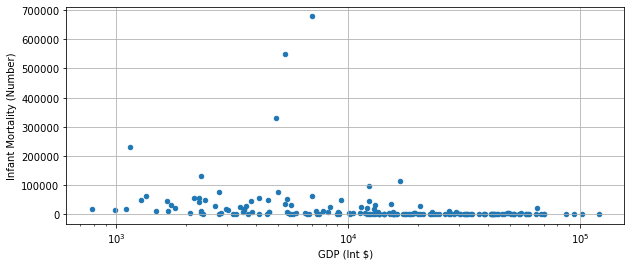

In [19]:
%matplotlib inline
gdp_pppVschildmort.plot(x=GDP, y=Death_NUM, kind='scatter', grid=True, logx=True, figsize=(10, 4))

The above plot shows GDP per capita income has a little relation or correlation with child death number. Looking at the graph, countries with GDP lesser than 104 had more child infant deaths above 100000, also above the first line. Unlike countries with GDP per capita 104 and above, that seemed to have child death number of almost at the same line with few deaths above the line.

Now, let's compare 10 countries with the lowest GDP per capita to 10 countries with the lowest infact death number:

In [21]:
# the 10 countries with lowest GDP
gdp_pppVschildmort.sort_values(GDP).head(10)

,country,GDP (Int $),Infant Mortality (Number)
26,Burundi,785,17413
31,Central African Republic,987,13322
98,Malawi,1107,19238
37,"Congo, Dem. Rep.",1147,228831
118,Niger,1279,48796
110,Mozambique,1338,60805
93,Liberia,1491,9886
32,Chad,1650,45065
161,Togo,1667,11947
97,Madagascar,1720,31456


This table above shows the countries with lowest GDP, and interestingly they have all high child death number and they all African country. This data somewhat supports my spearman rank correlation that tends towards a perfectly inverse rank correlation. Could it mean that African factors contribute to child mortality?. I'll say yes together with GDP per capita as indicated above.

Lets take a look at the countries with lowest child death number

In [22]:
gdp_pppVschildmort.sort_values(Death_NUM).head(10)

,country,GDP (Int $),Infant Mortality (Number)
124,Palau,18357,4
166,Tuvalu,4471,6
72,Iceland,58513,6
113,Nauru,12095,8
4,Antigua and Barbuda,22880,9
150,St. Kitts and Nevis,27608,9
96,Luxembourg,120962,14
108,Montenegro,23344,15
141,Seychelles,30517,20
152,St. Vincent and the Grenadines,13038,21


From my table above, I can say that child death number is affected by a county's GDP per capita to a some extent. 

# Conclusion:

GDP per capita  is one factor that affects child death number. There could be a whole lot of other factors, but from the analysis, GDP(PPP)- in one way or another affects citizens of a country and how they and the country are able to povide basic amentities for child care. 

To get more precise details other factors such as health care availability, security, etc can be put into consideratiion to measure the number of a country's child death number.